In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


# Loading in the raw data
#### Here the raw data is going to be loaded in and handled in order to begin manipulation with fields before using the resulting new dataframe for model generation.

In [3]:
raw_dataset = pd.read_excel("Fully_Merged_CAPA.xlsx")

In [4]:
raw_dataset.head()

,Source.Name,Number,Category,Date Advanced to Effectiveness,Date Assigned,Date Closed,Date Originated,Supplier,Status,Workflow,...,Address Line 2 (Additional CAPA Info),Address Line 3 (Additional CAPA Info),City (Additional CAPA Info),Country (Additional CAPA Info),Location Region/Province/State (Additional CAPA Info),Manufacturing Site (Additional CAPA Info),Sites Using Supplier (Additional CAPA Info),Supplier ID (Additional CAPA Info),Supplier Name (Additional CAPA Info),Amount of People
0,Sept2000_August2005_Combined.xlsx,CAPA20030001-0001,CAPA,NaN,NaN,NaN,05-Feb-2003 05:33:28 AM PST,NaN,Voided,CAPAs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Sept2000_August2005_Combined.xlsx,CAPA20040001-0001,CAPA,22-Sep-2004 06:25:41 AM PDT,17-Mar-2004 06:19:29 AM PST,22-Sep-2004 06:27:02 AM PDT,17-Mar-2004 06:01:10 AM PST,NaN,Closed,CAPAs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Sept2000_August2005_Combined.xlsx,CAPA20040002-0001,CAPA,12-Apr-2005 11:08:22 AM PDT,11-Nov-2004 05:12:40 AM PST,11-Aug-2005 12:46:10 PM PDT,14-May-2004 08:05:54 AM PDT,NaN,Closed,CAPAs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Sept2000_August2005_Combined.xlsx,CAPA2020040001-0001,CAPA,NaN,NaN,NaN,22-Apr-2004 06:49:45 AM PDT,NaN,Voided,CAPAs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Sept2000_August2005_Combined.xlsx,CAPA2020040002-0001,CAPA,22-Sep-2004 07:42:59 AM PDT,16-Jun-2004 09:51:23 AM PDT,22-Sep-2004 07:55:56 AM PDT,16-Jun-2004 09:08:16 AM PDT,NaN,Closed,CAPAs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
# Converting strings to datetime fields so that total time can be deduced
# as the difference between the assigned and the closed date
raw_dataset[['Date Assigned','Date Closed']] = raw_dataset[['Date Assigned','Date Closed' ]].apply(pd.to_datetime)

/Users/majedsalah/miniforge3/envs/tf/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Users/majedsalah/miniforge3/envs/tf/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Users/majedsalah/miniforge3/envs/tf/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this 

In [6]:
# Add new total time column (closed - assigned)
raw_dataset['Total Time'] = raw_dataset['Date Closed'] - raw_dataset['Date Assigned']

In [7]:
raw_dataset['Total Time']= pd.Series(raw_dataset['Total Time']).dt.days

In [8]:
# columns of interest that are going to be used for training
columns_to_use = ['Category', 'Status', 'Action Type (Detail)', 'Retired Field - Global Business Unit (Detail)',  'Retired Field - MITG Location (Detail)','Retired Field - Responsible Department (Detail)', 'Total Time', 'Amount of People', 'Triage Decision (Detail)', 'Is affected product in the field? (Detail)', 'Is the issue an existing or potential product issue? (Detail)']

In [9]:
training_df = raw_dataset[columns_to_use]
training_df = training_df.dropna(subset=['Total Time'])
training_df = training_df.loc[(training_df['Amount of People'] != 0)]
print(training_df['Total Time'].mean())
training_df

232.74507100510132


,Category,Status,Action Type (Detail),Retired Field - Global Business Unit (Detail),Retired Field - MITG Location (Detail),Retired Field - Responsible Department (Detail),Total Time,Amount of People,Triage Decision (Detail),Is affected product in the field? (Detail),Is the issue an existing or potential product issue? (Detail)
920,CAPA,Closed,Corrective/Preventive,Respiratory and Monitoring Solutions,Tijuana - Mexico [Nellcor],Quality Assurance,184.0,2,NaN,NaN,NaN
5549,CAPA,Closed,Corrective/Preventive,Surgical Devices,Ponce - Puerto Rico,Quality Assurance,352.0,2,NaN,NaN,NaN
5552,CAPA,Closed,Corrective/Preventive,Surgical Devices,"North Haven, CT [Mfg]",Quality Assurance,1.0,1,NaN,NaN,NaN
7148,Non-SPM SCAR,Closed,Corrective/Preventive,Vascular Therapies,Tijuana - Mexico [KenMex],Quality Assurance,157.0,2,NaN,NaN,NaN
7149,CAPA,Closed,Corrective/Preventive,Energy-based Devices,"Boulder, CO [Ebd Mfg]",Manufacturing;Planning,285.0,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
26362,CAPA,Closed,Corrective/Preventive,NaN,NaN,NaN,6.0,4,Classic CAPA,No,Yes
26390,CAPA,Closed,Corrective/Preventive,NaN,NaN,NaN,89.0,5,Fast Track CAPA,No,Yes
26393,CAPA,Closed,Corrective/Preventive,NaN,NaN,NaN,59.0,4,Fast Track CAPA,No,Yes
26404,CAPA,Closed,Corrective/Preventive,NaN,NaN,NaN,73.0,1,Fast Track CAPA,No,Yes


In [10]:
col_to_binary = ['Category', 'Status', 'Action Type (Detail)', 'Retired Field - Global Business Unit (Detail)', 'Retired Field - MITG Location (Detail)', 'Retired Field - Responsible Department (Detail)', 'Triage Decision (Detail)', 'Is affected product in the field? (Detail)', 'Is the issue an existing or potential product issue? (Detail)']

    
for col in col_to_binary:
    dummies = pd.Series(training_df[col]).str.get_dummies(sep=";")
    training_df = pd.concat([training_df, dummies], axis=1)
    
for col in col_to_binary:
    training_df.drop(col, axis=1, inplace=True)
    
training_df

,Total Time,Amount of People,CAPA,Non-SPM SCAR,Closed,Corrective/Preventive,Preventive Only,Aortic & Peripheral Vascular,Contract Manufacturing,Corporate,...,Training,Validation,Warehouse,Warehouse - Syneture,Classic CAPA,Fast Track CAPA,No,Yes,No,Yes
920,184.0,2,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5549,352.0,2,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5552,1.0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7148,157.0,2,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7149,285.0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26362,6.0,4,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
26390,89.0,5,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
26393,59.0,4,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
26404,73.0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


In [11]:
training_df = training_df.dropna(subset=['Total Time'])
training_df['Amount of People'] = (training_df['Amount of People'] - training_df['Amount of People'].min()) / (training_df['Amount of People'].max() - training_df['Amount of People'].min())    

In [12]:
train_dataset = training_df.sample(frac=0.8, random_state=10)
test_dataset = training_df.drop(train_dataset.index)

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Total Time')
test_labels = test_features.pop('Total Time')

# Normalizing the data
##### Here the data is going to be normalized by applying numerical values for categories and applying weight changes for already numerical values.

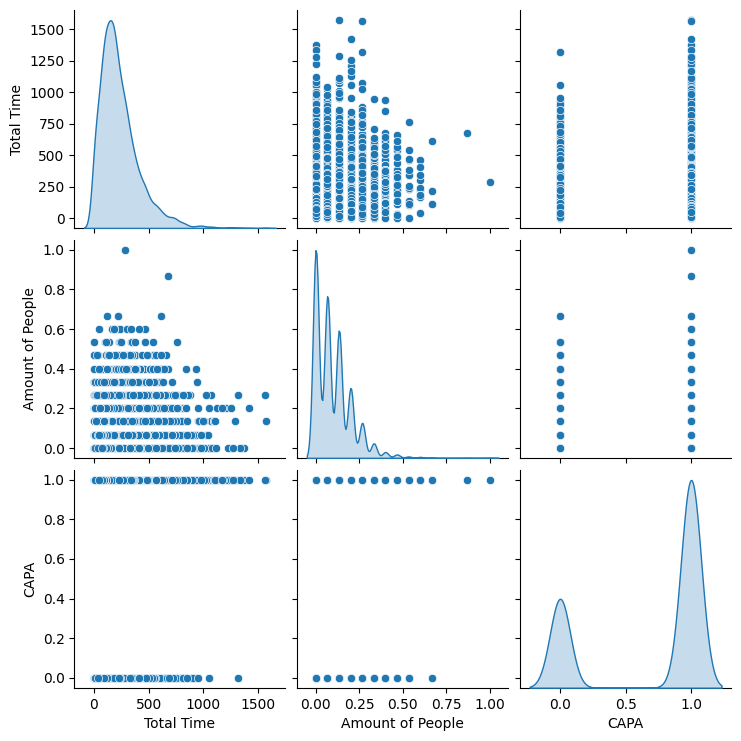

In [14]:
sns.pairplot(data=training_df[['Total Time', 'Amount of People', 'CAPA']], diag_kind='kde')

In [15]:
train_features.head()

,Amount of People,CAPA,Non-SPM SCAR,Closed,Corrective/Preventive,Preventive Only,Aortic & Peripheral Vascular,Contract Manufacturing,Corporate,Early Technologies,...,Training,Validation,Warehouse,Warehouse - Syneture,Classic CAPA,Fast Track CAPA,No,Yes,No,Yes
18687,0.133333,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19915,0.000000,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13849,0.133333,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18794,0.000000,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20308,0.133333,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
test_features.head()

,Amount of People,CAPA,Non-SPM SCAR,Closed,Corrective/Preventive,Preventive Only,Aortic & Peripheral Vascular,Contract Manufacturing,Corporate,Early Technologies,...,Training,Validation,Warehouse,Warehouse - Syneture,Classic CAPA,Fast Track CAPA,No,Yes,No,Yes
920,0.066667,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7148,0.066667,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7163,0.066667,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7193,0.000000,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7206,0.000000,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
training_df

,Total Time,Amount of People,CAPA,Non-SPM SCAR,Closed,Corrective/Preventive,Preventive Only,Aortic & Peripheral Vascular,Contract Manufacturing,Corporate,...,Training,Validation,Warehouse,Warehouse - Syneture,Classic CAPA,Fast Track CAPA,No,Yes,No,Yes
920,184.0,0.066667,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5549,352.0,0.066667,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5552,1.0,0.000000,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7148,157.0,0.066667,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7149,285.0,0.000000,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26362,6.0,0.200000,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
26390,89.0,0.266667,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
26393,59.0,0.200000,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
26404,73.0,0.000000,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


In [18]:
linear_model = tf.keras.Sequential([
    layers.Dense(units=1)
])

Metal device set to: Apple M1 Pro


2022-11-12 20:29:34.263860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-12 20:29:34.263977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
linear_model.predict(train_features)

 58/182 [========>.....................] - ETA: 0s 

2022-11-12 20:29:34.307779: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-12 20:29:34.394834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 0s 873us/step


array([[-0.061],
       [ 0.296],
       [ 0.143],
       ...,
       [-0.043],
       [ 0.138],
       [ 0.192]], dtype=float32)

In [20]:
linear_model.layers[0].kernel

<tf.Variable 'dense/kernel:0' shape=(240, 1) dtype=float32, numpy=
array([[-0.002],
       [ 0.062],
       [-0.09 ],
       [ 0.027],
       [ 0.135],
       [ 0.08 ],
       [ 0.051],
       [-0.038],
       [-0.124],
       [ 0.126],
       [ 0.083],
       [ 0.058],
       [-0.089],
       [ 0.064],
       [ 0.019],
       [-0.121],
       [ 0.05 ],
       [-0.056],
       [-0.032],
       [ 0.077],
       [-0.081],
       [-0.065],
       [ 0.143],
       [-0.132],
       [ 0.042],
       [ 0.114],
       [ 0.034],
       [ 0.137],
       [ 0.083],
       [-0.011],
       [ 0.05 ],
       [-0.032],
       [ 0.132],
       [-0.13 ],
       [-0.141],
       [-0.07 ],
       [ 0.02 ],
       [-0.14 ],
       [-0.013],
       [-0.13 ],
       [ 0.098],
       [ 0.082],
       [-0.116],
       [-0.147],
       [ 0.091],
       [-0.014],
       [ 0.069],
       [ 0.129],
       [ 0.08 ],
       [ 0.007],
       [ 0.005],
       [-0.01 ],
       [-0.031],
       [ 0.039],
       [ 0.127]

In [21]:
linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss='mean_absolute_error')
train_features.head()

,Amount of People,CAPA,Non-SPM SCAR,Closed,Corrective/Preventive,Preventive Only,Aortic & Peripheral Vascular,Contract Manufacturing,Corporate,Early Technologies,...,Training,Validation,Warehouse,Warehouse - Syneture,Classic CAPA,Fast Track CAPA,No,Yes,No,Yes
18687,0.133333,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19915,0.000000,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13849,0.133333,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18794,0.000000,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20308,0.133333,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

2022-11-12 20:29:34.750613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-12 20:29:35.315277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 38.2 s, sys: 23.1 s, total: 1min 1s
Wall time: 51 s


In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,111.756409,114.389145,95
96,111.738739,114.415085,96
97,111.705841,114.393791,97
98,111.682831,114.369446,98
99,111.676025,114.396103,99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 200])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Days]')
  plt.legend()
  plt.grid(True)

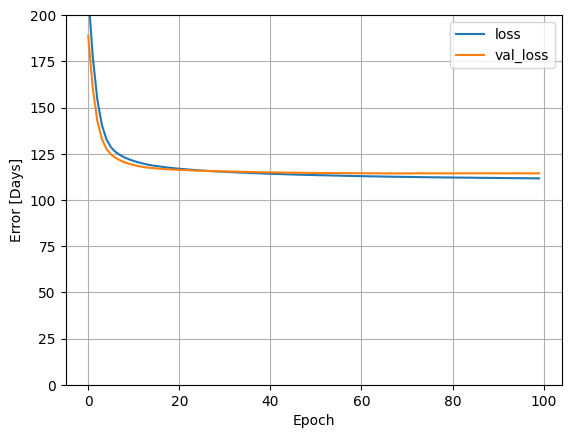

In [25]:
plot_loss(history)

In [26]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(2048, activation='relu'),
      layers.Dense(2048, activation='relu'),
      layers.Dense(2, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.00001))
  return model

In [27]:
dnn_model = build_and_compile_model()
# dnn_model.summary()

In [28]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2022-11-12 20:30:26.113535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-12 20:30:27.850891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1min 3s, sys: 30.4 s, total: 1min 34s
Wall time: 1min 37s


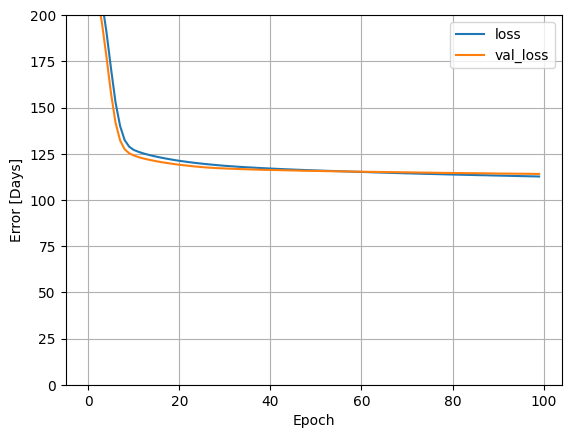

In [29]:
plot_loss(history)

41/46 [=========================>....] - ETA: 0s

2022-11-12 20:32:03.764270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 0s 5ms/step


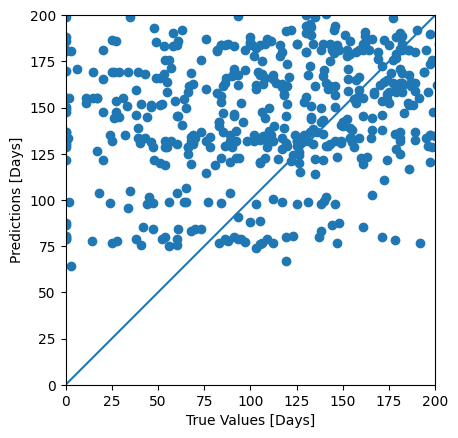

In [30]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Days]')
plt.ylabel('Predictions [Days]')
lims = [0, 200]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [31]:
for i in range(len(test_predictions)):
    print(test_predictions[i], test_labels)

284.13367 920      184.0
7148     157.0
7163     158.0
7193      78.0
7206      57.0
         ...  
26335     33.0
26343     27.0
26355     31.0
26362      6.0
26393     59.0
Name: Total Time, Length: 1451, dtype: float64
180.21631 920      184.0
7148     157.0
7163     158.0
7193      78.0
7206      57.0
         ...  
26335     33.0
26343     27.0
26355     31.0
26362      6.0
26393     59.0
Name: Total Time, Length: 1451, dtype: float64
155.19382 920      184.0
7148     157.0
7163     158.0
7193      78.0
7206      57.0
         ...  
26335     33.0
26343     27.0
26355     31.0
26362      6.0
26393     59.0
Name: Total Time, Length: 1451, dtype: float64
134.00053 920      184.0
7148     157.0
7163     158.0
7193      78.0
7206      57.0
         ...  
26335     33.0
26343     27.0
26355     31.0
26362      6.0
26393     59.0
Name: Total Time, Length: 1451, dtype: float64
132.15224 920      184.0
7148     157.0
7163     158.0
7193      78.0
7206      57.0
         ...  
26335     33

In [32]:
print(test_labels)

920      184.0
7148     157.0
7163     158.0
7193      78.0
7206      57.0
         ...  
26335     33.0
26343     27.0
26355     31.0
26362      6.0
26393     59.0
Name: Total Time, Length: 1451, dtype: float64


920      100.133667
7148      23.216309
7163      -2.806183
7193      56.000534
7206      75.152237
            ...    
26335    117.644272
26343    126.739716
26355    124.416138
26362    310.830902
26393     94.739716
Name: Total Time, Length: 1451, dtype: float64


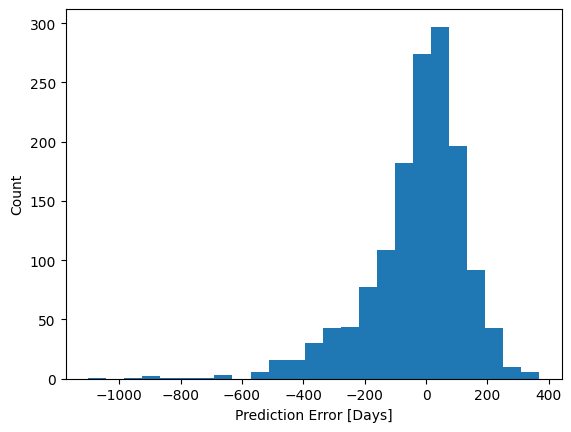

In [33]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Days]')
_ = plt.ylabel('Count')
print(error)

In [34]:
total = 0
for x in error:
    total += abs(x)
    print(x, total)
    
166665 / 1451

100.1336669921875 100.1336669921875
23.21630859375 123.3499755859375
-2.806182861328125 126.15615844726562
56.00053405761719 182.1566925048828
75.15223693847656 257.3089294433594
-154.84776306152344 412.1566925048828
57.58653259277344 469.74322509765625
-8.876930236816406 478.62015533447266
116.71925354003906 595.3394088745117
77.70187377929688 673.0412826538086
-356.4195556640625 1029.460838317871
-270.8200225830078 1300.280860900879
95.46650695800781 1395.7473678588867
125.10368347167969 1520.8510513305664
-7.0460968017578125 1527.8971481323242
3.1522369384765625 1531.0493850708008
-47.453643798828125 1578.503028869629
15.350921630859375 1593.8539505004883
-89.45364379882812 1683.3075942993164
28.546356201171875 1711.8539505004883
15.40789794921875 1727.261848449707
-257.40650177001953 1984.6683502197266
34.75543975830078 2019.4237899780273
-8.330307006835938 2027.7540969848633
18.51220703125 2046.2663040161133
77.30410766601562 2123.570411682129
94.77317810058594 2218.343589782715
7

114.86216402481048

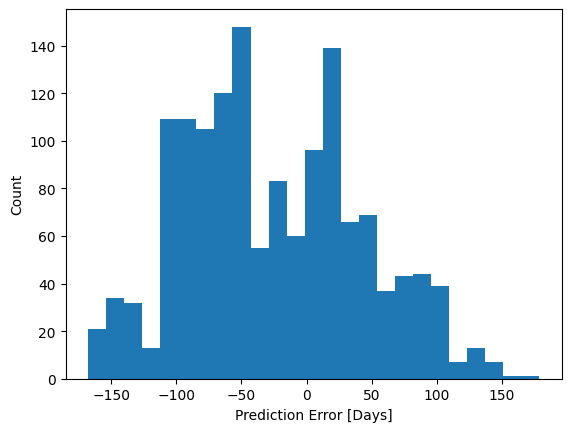

In [35]:
error = test_predictions - 232
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Days]')
_ = plt.ylabel('Count')

In [36]:
print(error)

[ 52.134 -51.784 -76.806 ... -76.584  84.831 -78.26 ]
